In [1]:
#pip install torch torchvision numpy pandas opencv-python scikit-learn

In [ ]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

### Setting and parameters

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 14
NUM_EPOCHS = 20
LR = 1e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_DIR_TRAIN = '/kaggle/input/grand-xray-slam-division-b/train2/'

### Load train data

In [ ]:
try:
    train_df = pd.read_csv('/kaggle/input/grand-xray-slam-division-b/train2.csv')
    print(f"Loaded train2.csv with {len(train_df)} rows")
except FileNotFoundError:
    print("Error: train2.csv not found. Ensure dataset is attached.")
    raise

label_columns = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
    'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
    'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
]

missing_cols = [col for col in label_columns if col not in train_df.columns]
if missing_cols:
    raise KeyError(f"Missing columns: {missing_cols}")

subset_frac = 0.05
df_small = train_df.sample(frac=subset_frac, random_state=42)

# split into train and validation (80/20)
train_data, val_data = train_test_split(
    df_small, test_size=0.2, random_state=42, stratify=df_small['No Finding']
)
print(f"Train samples: {len(train_data)}, Validation samples: {len(val_data)}")

Loaded train1.csv with 108494 rows
Train samples: 4340, Validation samples: 1085


### Augmentations

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE[0]),   
    A.PadIfNeeded(min_height=IMG_SIZE[0], min_width=IMG_SIZE[1], border_mode=0),  
    
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.02, scale_limit=0.05, rotate_limit=5, 
        border_mode=0, p=0.3
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.05, contrast_limit=0.05, p=0.3
    ),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.2),
    
    A.Normalize(mean=(0.5,), std=(0.5,)),  
    ToTensorV2()
])

val_transform = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE[0]),
    A.PadIfNeeded(min_height=IMG_SIZE[0], min_width=IMG_SIZE[1], border_mode=0),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

### Processing images

In [ ]:
class ChestXRayDataset(Dataset):
    def __init__(self, df: pd.DataFrame, image_dir: str, img_size=IMG_SIZE, 
                             is_test=False, label_cols=None, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.img_size = img_size
        self.is_test = is_test
        self.label_cols = label_cols
        self.transform = transform

        if not os.path.exists(self.image_dir):
            raise FileNotFoundError(f"Image directory {self.image_dir} not found.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['Image_name']
        img_path = os.path.join(self.image_dir, img_name)
    
        # load grayscale image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None or img.size == 0:
            img = np.zeros(self.img_size, dtype=np.uint8)
        else:
            img = cv2.resize(img, self.img_size)
    
        # make (H, W, 1) for albumentations
        img = np.expand_dims(img, axis=-1)
    
        # augmentation
        if self.transform:
            # albumentations expects dict
            img = self.transform(image=img)["image"]
        else:
            # fallback: to tensor
            img = transforms.ToTensor()(img)
    
        if self.is_test:
            return img
        else:
            labels = torch.tensor(row[self.label_cols].values.astype(np.float32))
            return img, labels

### Wrapper

In [ ]:
class CNNWrapper(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.backbone, self.feature_dim = _get_backbone(model_name)
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.fc(features)


    def _get_backbone(self, model_name, pretrained=True):
        if model_name == "resnet18":
            model = models.resnet18(pretrained=pretrained)
            model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
            feature_dim = model.fc.in_features
            model.fc = nn.Identity()

        elif model_name == "resnext50":
            model = models.resnext50_32x4d(pretrained=pretrained)
            model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
            feature_dim = model.fc.in_features
            model.fc = nn.Identity()

        elif model_name == "efficientnet_b0":
            model = models.efficientnet_b0(pretrained=pretrained)
            model.features[0][0] = nn.Conv2d(1, 32, 3, 2, 1, bias=False)
            feature_dim = model.classifier[1].in_features
            model.classifier = nn.Identity()

        elif model_name == "densenet121":
            model = models.densenet121(pretrained=pretrained)
            model.features.conv0 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
            feature_dim = model.classifier.in_features
            model.classifier = nn.Identity()

        elif model_name == "simplecnn":
            model = SimpleCNN()
            feature_dim = model.fc_out_layer.in_features
            model.fc_out = nn.Identity()

        else:
            raise ValueError(f"Unknown model: {model_name}")

        return model, feature_dim


### Baseline CNN model

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.flattened_size = 128 * 26 * 26
        self.fc = nn.Linear(self.flattened_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc_out_layer = nn.Linear(128, num_classes)
        self.fc_out = nn.Identity()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.dropout(x)
        return x  # feature vector


### Metrics

In [ ]:
class MetricCalculator:
    def __init__(self, class_names=label_columns):
        self.class_names = class_names
    
    def compute_auc(self, y_true, y_pred):
        """Вычисляет средний AUC и AUC по каждому классу."""
        aucs = []
        for i in range(y_true.shape[1]):
            try:
                auc = roc_auc_score(y_true[:, i], y_pred[:, i])
            except ValueError:
                auc = np.nan  # если для класса нет положительных/отрицательных примеров
            aucs.append(auc)
        aucs = np.array(aucs, dtype=np.float32)
        return np.nanmean(aucs), aucs
    
    def print_auc(self, auc_mean, auc_per_class, phase="Train"):
        print(f"\n{phase} AUC: {auc_mean:.4f}")


### Plots

In [ ]:
def plot_learning_curves(model_name, history, num_epochs=NUM_EPOCHS):
    epochs = np.arange(1, num_epochs+1)
    os.makedirs("plots", exist_ok=True)
    
    plt.figure(figsize=(10,4))
    # loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train']['loss'], label='train loss')
    plt.plot(epochs, history['val']['loss'], label='val loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.title(f'Loss {model_name}')
    # auc
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train']['auc'], label='train AUC')
    plt.plot(epochs, history['val']['auc'], label='val AUC')
    plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.legend()
    plt.title(f'AUC {model_name}')

    plt.tight_layout()

    save_path = os.path.join("plots", f"{model_name}_learning_curves_{num_epochs}_epochs.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved learning curves to: {save_path}")

In [ ]:
def bar_aucs(aucs_per_classes, model_name="model"):
    os.makedirs("plots", exist_ok=True)

    plt.figure(figsize=(30, 4))
    plt.bar(label_columns, aucs_per_classes)
    plt.xlabel('Class')
    plt.ylabel('AUC')
    plt.title(f'AUCs by Classes ({model_name})')

    save_path = os.path.join("plots", f"{model_name}_aucs_per_class.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved per-class AUC bar chart to: {save_path}")

### Loaders

In [ ]:
train_dataset = ChestXRayDataset(train_data, IMAGE_DIR_TRAIN, img_size=IMG_SIZE, 
                                 is_test=False, label_cols=label_columns, transform=train_transform)

val_dataset = ChestXRayDataset(val_data, IMAGE_DIR_TRAIN, img_size=IMG_SIZE, 
                               is_test=False, label_cols=label_columns, transform=val_transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3, pin_memory=True)

### Save results

In [ ]:
def save_results_csv(model_name, history, num_epochs, lr, filepath="results.csv"):
    row = {
        "Model": model_name,
        "AUC": max(history['val']['auc']),
        "epochs": num_epochs,
        "lr": lr
    }

    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    else:
        df = pd.DataFrame([row])

    df.to_csv(filepath, index=False)

### Train loop

In [ ]:
def training_and_validation(model_name, model, optimizer, criterion, num_epochs=NUM_EPOCHS, lr=LR):
    print(f'Model_name: {model_name}')
    
    metric_calculator = MetricCalculator()

    # initialize history (только loss и AUC)
    history = {
        'train': {'loss': [], 'auc': []},
        'val': {'loss': [], 'auc': []}
    }

    best_val_auc = 0.0
    best_epoch = 0
    best_val_auc_per_class = None  # здесь будем хранить AUC по классам для лучшей модели

    for epoch in range(7, num_epochs):
         # ---------------------- TRAIN ----------------------
        model.train()
        running_loss = 0.0
        train_labels, train_preds = [], []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - train", mininterval=20)
        for batch_idx, (imgs, labels) in enumerate(pbar):
        
            imgs = imgs.to(DEVICE, dtype=torch.float)
            labels = labels.to(DEVICE, dtype=torch.float)
        
            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item() * imgs.size(0)
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            train_preds.append(probs)
            train_labels.append(labels.cpu().numpy())
        
            # Обновляем tqdm
            pbar.set_postfix({'Loss': f"{running_loss / ((pbar.n+1)*BATCH_SIZE):.2f}"})

            if batch_idx % 1000 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] Batch {batch_idx}/{len(train_loader)} | "
                      f"Loss: {loss.item():.4f}", flush=True)


        train_preds = np.vstack(train_preds)
        train_labels = np.vstack(train_labels)
        train_epoch_loss = running_loss / len(train_dataset)
        train_auc_mean, train_auc_per_class = metric_calculator.compute_auc(train_labels, train_preds)

        history['train']['loss'].append(train_epoch_loss)
        history['train']['auc'].append(train_auc_mean)

        print(f"\nEpoch {epoch+1} Train loss: {train_epoch_loss:.2f}")
        metric_calculator.print_auc(train_auc_mean, train_auc_per_class, phase="Train")

        # ---------------------- VALIDATION ----------------------
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc="Validation"):
                imgs = imgs.to(DEVICE, dtype=torch.float)
                labels = labels.to(DEVICE, dtype=torch.float)
        
                logits = model(imgs)
                loss = criterion(logits, labels)
                val_loss += loss.item() * imgs.size(0)
        
                probs = torch.sigmoid(logits).detach().cpu().numpy()
                val_preds.append(probs)
                val_labels.append(labels.cpu().numpy())

                del imgs, labels, logits, probs
        torch.cuda.empty_cache()
        
        val_preds = np.vstack(val_preds)
        val_labels = np.vstack(val_labels)
        
        val_epoch_loss = val_loss / len(val_dataset)
        val_auc_mean, val_auc_per_class = metric_calculator.compute_auc(val_labels, val_preds)

        history['val']['loss'].append(val_epoch_loss)
        history['val']['auc'].append(val_auc_mean)

        print(f"\nEpoch {epoch+1} Validation loss: {val_epoch_loss:.2f}")
        metric_calculator.print_auc(val_auc_mean, val_auc_per_class, phase="Validation")


        #if (epoch+1)%5 == 0: plot_learning_curves(model_name, history, epoch+1)

        # ---------------------- SAVE BEST MODEL ----------------------
        if val_auc_mean > best_val_auc:
            best_val_auc = val_auc_mean
            best_val_auc_per_class = val_auc_per_class.copy()  # сохраняем для bar-графика
            best_epoch = epoch + 1
            save_path = f"best_{model_name}_epoch_{best_epoch}_auc{best_val_auc:.4f}.pth"
            torch.save(model.state_dict(), save_path)
            print(f"\nSaved new best model at epoch {best_epoch} with AUC={best_val_auc:.4f}: {save_path}")

    print(f"\nTraining finished. Best validation AUC={best_val_auc:.4f} at epoch {best_epoch}")

    
    # ---------------------- PLOTS & SAVE HISTORY ----------------------
    #plot_learning_curves(model_name, history, num_epochs)
    bar_aucs(best_val_auc_per_class, model_name)

    save_results_csv(model_name, history, num_epochs, lr)

### Main

In [ ]:
MODEL_NAMES = ["simplecnn", "resnet18", "resnext50", "efficientnet_b0", "densenet121", "efficientnet_v2_s"]

Model_name: simplecnn


Epoch 1/10 - train: 100%|██████████| 543/543 [01:29<00:00,  6.05it/s, Loss=0.58]


Epoch 1 train loss: 0.58

Train metrics
AUC: 0.6
F1: 0.3
Precision: 0.3
Recall: 0.2

Problematic classes:
  Atelectasis: AUC=0.582, F1=0.440
  Cardiomegaly: AUC=0.566, F1=0.358
  Consolidation: AUC=0.606, F1=0.332
  Edema: AUC=0.597, F1=0.337
  Enlarged Cardiomediastinum: AUC=0.643, F1=0.472
  Fracture: AUC=0.502, F1=0.109
  Lung Lesion: AUC=0.496, F1=0.054
  Lung Opacity: AUC=0.605, F1=0.556
  No Finding: AUC=0.610, F1=0.273
  Pleural Effusion: AUC=0.585, F1=0.376
  Pleural Other: AUC=0.491, F1=0.007
  Pneumonia: AUC=0.481, F1=0.069
  Pneumothorax: AUC=0.463, F1=0.014
  Support Devices: AUC=0.563, F1=0.372


Validation: 100%|██████████| 136/136 [00:21<00:00,  6.31it/s]


Epoch 1 validation loss: 0.74

Validation metrics
AUC: 0.7
F1: 0.4
Precision: 0.4
Recall: 0.3

Problematic classes:
  Atelectasis: AUC=0.794, F1=0.632
  Cardiomegaly: AUC=0.818, F1=0.641
  Consolidation: AUC=0.794, F1=0.514
  Edema: AUC=0.816, F1=0.535
  Fracture: AUC=0.627, F1=0.000
  Lung Lesion: AUC=0.566, F1=0.000
  No Finding: AUC=0.718, F1=0.402
  Pleural Effusion: AUC=0.748, F1=0.536
  Pleural Other: AUC=0.466, F1=0.000
  Pneumonia: AUC=0.645, F1=0.000
  Pneumothorax: AUC=0.511, F1=0.000
  Support Devices: AUC=0.788, F1=0.410


Epoch 2/10 - train: 100%|██████████| 543/543 [01:04<00:00,  8.38it/s, Loss=0.49]


Epoch 2 train loss: 0.49

Train metrics
AUC: 0.7
F1: 0.3
Precision: 0.4
Recall: 0.3

Problematic classes:
  Atelectasis: AUC=0.723, F1=0.553
  Cardiomegaly: AUC=0.750, F1=0.527
  Consolidation: AUC=0.742, F1=0.419
  Edema: AUC=0.730, F1=0.386
  Enlarged Cardiomediastinum: AUC=0.820, F1=0.655
  Fracture: AUC=0.611, F1=0.076
  Lung Lesion: AUC=0.530, F1=0.019
  Lung Opacity: AUC=0.747, F1=0.668
  No Finding: AUC=0.685, F1=0.410
  Pleural Effusion: AUC=0.691, F1=0.450
  Pleural Other: AUC=0.518, F1=0.000
  Pneumonia: AUC=0.573, F1=0.043
  Pneumothorax: AUC=0.530, F1=0.006
  Support Devices: AUC=0.712, F1=0.479


Validation: 100%|██████████| 136/136 [00:14<00:00,  9.12it/s]


Epoch 2 validation loss: 0.74

Validation metrics
AUC: 0.8
F1: 0.4
Precision: 0.4
Recall: 0.5

Problematic classes:
  Atelectasis: AUC=0.823, F1=0.679
  Consolidation: AUC=0.818, F1=0.628
  Edema: AUC=0.848, F1=0.632
  Fracture: AUC=0.771, F1=0.000
  Lung Lesion: AUC=0.596, F1=0.000
  No Finding: AUC=0.754, F1=0.493
  Pleural Effusion: AUC=0.759, F1=0.581
  Pleural Other: AUC=0.525, F1=0.000
  Pneumonia: AUC=0.728, F1=0.000
  Pneumothorax: AUC=0.604, F1=0.000


Epoch 3/10 - train: 100%|██████████| 543/543 [01:04<00:00,  8.41it/s, Loss=0.46]


Epoch 3 train loss: 0.46

Train metrics
AUC: 0.7
F1: 0.4
Precision: 0.4
Recall: 0.3

Problematic classes:
  Atelectasis: AUC=0.755, F1=0.592
  Cardiomegaly: AUC=0.806, F1=0.617
  Consolidation: AUC=0.781, F1=0.484
  Edema: AUC=0.785, F1=0.474
  Fracture: AUC=0.677, F1=0.088
  Lung Lesion: AUC=0.568, F1=0.008
  No Finding: AUC=0.735, F1=0.481
  Pleural Effusion: AUC=0.727, F1=0.491
  Pleural Other: AUC=0.570, F1=0.000
  Pneumonia: AUC=0.655, F1=0.037
  Pneumothorax: AUC=0.527, F1=0.000
  Support Devices: AUC=0.773, F1=0.564


Validation: 100%|██████████| 136/136 [00:15<00:00,  9.03it/s]


Epoch 3 validation loss: 0.73

Validation metrics
AUC: 0.8
F1: 0.4
Precision: 0.4
Recall: 0.5

Problematic classes:
  Atelectasis: AUC=0.836, F1=0.691
  Consolidation: AUC=0.832, F1=0.652
  Edema: AUC=0.862, F1=0.667
  Fracture: AUC=0.783, F1=0.000
  Lung Lesion: AUC=0.606, F1=0.000
  No Finding: AUC=0.773, F1=0.542
  Pleural Effusion: AUC=0.771, F1=0.586
  Pleural Other: AUC=0.524, F1=0.000
  Pneumonia: AUC=0.759, F1=0.000
  Pneumothorax: AUC=0.630, F1=0.000


Epoch 4/10 - train: 100%|██████████| 543/543 [01:03<00:00,  8.49it/s, Loss=0.44]


Epoch 4 train loss: 0.44

Train metrics
AUC: 0.7
F1: 0.4
Precision: 0.5
Recall: 0.4

Problematic classes:
  Atelectasis: AUC=0.768, F1=0.619
  Cardiomegaly: AUC=0.822, F1=0.635
  Consolidation: AUC=0.805, F1=0.521
  Edema: AUC=0.808, F1=0.511
  Fracture: AUC=0.714, F1=0.069
  Lung Lesion: AUC=0.569, F1=0.004
  No Finding: AUC=0.751, F1=0.482
  Pleural Effusion: AUC=0.747, F1=0.517
  Pleural Other: AUC=0.599, F1=0.000
  Pneumonia: AUC=0.689, F1=0.040
  Pneumothorax: AUC=0.569, F1=0.000
  Support Devices: AUC=0.816, F1=0.618


Validation: 100%|██████████| 136/136 [00:15<00:00,  9.03it/s]


Epoch 4 validation loss: 0.73

Validation metrics
AUC: 0.8
F1: 0.4
Precision: 0.4
Recall: 0.5

Problematic classes:
  Atelectasis: AUC=0.829, F1=0.683
  Consolidation: AUC=0.827, F1=0.641
  Edema: AUC=0.860, F1=0.680
  Fracture: AUC=0.788, F1=0.000
  Lung Lesion: AUC=0.615, F1=0.000
  No Finding: AUC=0.780, F1=0.507
  Pleural Effusion: AUC=0.771, F1=0.588
  Pleural Other: AUC=0.563, F1=0.000
  Pneumonia: AUC=0.753, F1=0.000
  Pneumothorax: AUC=0.641, F1=0.000


Epoch 5/10 - train: 100%|██████████| 543/543 [01:04<00:00,  8.36it/s, Loss=0.43]


Epoch 5 train loss: 0.43

Train metrics
AUC: 0.8
F1: 0.4
Precision: 0.5
Recall: 0.4

Problematic classes:
  Atelectasis: AUC=0.780, F1=0.636
  Cardiomegaly: AUC=0.842, F1=0.669
  Consolidation: AUC=0.818, F1=0.549
  Edema: AUC=0.809, F1=0.511
  Fracture: AUC=0.725, F1=0.068
  Lung Lesion: AUC=0.582, F1=0.004
  No Finding: AUC=0.762, F1=0.491
  Pleural Effusion: AUC=0.753, F1=0.546
  Pleural Other: AUC=0.625, F1=0.000
  Pneumonia: AUC=0.705, F1=0.047
  Pneumothorax: AUC=0.594, F1=0.000
  Support Devices: AUC=0.827, F1=0.627


Validation: 100%|██████████| 136/136 [00:15<00:00,  9.06it/s]


Epoch 5 validation loss: 0.72

Validation metrics
AUC: 0.8
F1: 0.4
Precision: 0.4
Recall: 0.5

Problematic classes:
  Atelectasis: AUC=0.833, F1=0.689
  Consolidation: AUC=0.839, F1=0.635
  Edema: AUC=0.869, F1=0.650
  Fracture: AUC=0.805, F1=0.000
  Lung Lesion: AUC=0.603, F1=0.000
  No Finding: AUC=0.787, F1=0.503
  Pleural Effusion: AUC=0.773, F1=0.571
  Pleural Other: AUC=0.624, F1=0.000
  Pneumonia: AUC=0.767, F1=0.000
  Pneumothorax: AUC=0.672, F1=0.000


Epoch 6/10 - train: 100%|██████████| 543/543 [01:04<00:00,  8.38it/s, Loss=0.42]


Epoch 6 train loss: 0.42

Train metrics
AUC: 0.8
F1: 0.4
Precision: 0.5
Recall: 0.4

Problematic classes:
  Atelectasis: AUC=0.792, F1=0.637
  Cardiomegaly: AUC=0.854, F1=0.686
  Consolidation: AUC=0.823, F1=0.561
  Edema: AUC=0.825, F1=0.526
  Fracture: AUC=0.745, F1=0.057
  Lung Lesion: AUC=0.587, F1=0.004
  No Finding: AUC=0.772, F1=0.501
  Pleural Effusion: AUC=0.760, F1=0.530
  Pleural Other: AUC=0.629, F1=0.000
  Pneumonia: AUC=0.697, F1=0.044
  Pneumothorax: AUC=0.599, F1=0.000
  Support Devices: AUC=0.830, F1=0.637


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.82it/s]


Epoch 6 validation loss: 0.72

Validation metrics
AUC: 0.8
F1: 0.4
Precision: 0.4
Recall: 0.5

Problematic classes:
  Atelectasis: AUC=0.835, F1=0.695
  Consolidation: AUC=0.838, F1=0.657
  Edema: AUC=0.869, F1=0.687
  Fracture: AUC=0.810, F1=0.000
  Lung Lesion: AUC=0.614, F1=0.000
  No Finding: AUC=0.792, F1=0.581
  Pleural Effusion: AUC=0.776, F1=0.584
  Pleural Other: AUC=0.632, F1=0.000
  Pneumonia: AUC=0.772, F1=0.000
  Pneumothorax: AUC=0.690, F1=0.000


Epoch 7/10 - train: 100%|██████████| 543/543 [01:04<00:00,  8.48it/s, Loss=0.42]


Epoch 7 train loss: 0.42

Train metrics
AUC: 0.8
F1: 0.4
Precision: 0.6
Recall: 0.4

Problematic classes:
  Atelectasis: AUC=0.794, F1=0.643
  Cardiomegaly: AUC=0.854, F1=0.683
  Consolidation: AUC=0.824, F1=0.559
  Edema: AUC=0.829, F1=0.527
  Fracture: AUC=0.762, F1=0.085
  Lung Lesion: AUC=0.584, F1=0.000
  No Finding: AUC=0.783, F1=0.536
  Pleural Effusion: AUC=0.765, F1=0.541
  Pleural Other: AUC=0.631, F1=0.000
  Pneumonia: AUC=0.726, F1=0.025
  Pneumothorax: AUC=0.599, F1=0.006
  Support Devices: AUC=0.843, F1=0.652


Validation: 100%|██████████| 136/136 [00:15<00:00,  9.05it/s]


Epoch 7 validation loss: 0.72

Validation metrics
AUC: 0.8
F1: 0.4
Precision: 0.4
Recall: 0.5

Problematic classes:
  Atelectasis: AUC=0.836, F1=0.683
  Consolidation: AUC=0.842, F1=0.670
  Edema: AUC=0.872, F1=0.677
  Fracture: AUC=0.806, F1=0.000
  Lung Lesion: AUC=0.611, F1=0.000
  No Finding: AUC=0.797, F1=0.598
  Pleural Effusion: AUC=0.779, F1=0.585
  Pleural Other: AUC=0.615, F1=0.000
  Pneumonia: AUC=0.772, F1=0.000
  Pneumothorax: AUC=0.676, F1=0.000


Epoch 8/10 - train: 100%|██████████| 543/543 [01:03<00:00,  8.50it/s, Loss=0.41]


Epoch 8 train loss: 0.41

Train metrics
AUC: 0.8
F1: 0.4
Precision: 0.5
Recall: 0.4

Problematic classes:
  Atelectasis: AUC=0.801, F1=0.658
  Cardiomegaly: AUC=0.856, F1=0.692
  Consolidation: AUC=0.839, F1=0.580
  Edema: AUC=0.841, F1=0.552
  Fracture: AUC=0.763, F1=0.069
  Lung Lesion: AUC=0.592, F1=0.004
  No Finding: AUC=0.795, F1=0.537
  Pleural Effusion: AUC=0.779, F1=0.561
  Pleural Other: AUC=0.653, F1=0.000
  Pneumonia: AUC=0.724, F1=0.032
  Pneumothorax: AUC=0.613, F1=0.000
  Support Devices: AUC=0.851, F1=0.668


Validation: 100%|██████████| 136/136 [00:14<00:00,  9.08it/s]


Epoch 8 validation loss: 0.72

Validation metrics
AUC: 0.8
F1: 0.5
Precision: 0.4
Recall: 0.5

Problematic classes:
  Atelectasis: AUC=0.838, F1=0.694
  Consolidation: AUC=0.846, F1=0.670
  Edema: AUC=0.872, F1=0.685
  Fracture: AUC=0.801, F1=0.000
  Lung Lesion: AUC=0.623, F1=0.000
  No Finding: AUC=0.803, F1=0.620
  Pleural Effusion: AUC=0.782, F1=0.590
  Pleural Other: AUC=0.633, F1=0.000
  Pneumonia: AUC=0.779, F1=0.000
  Pneumothorax: AUC=0.689, F1=0.000


Epoch 9/10 - train: 100%|██████████| 543/543 [01:03<00:00,  8.50it/s, Loss=0.41]


Epoch 9 train loss: 0.41

Train metrics
AUC: 0.8
F1: 0.4
Precision: 0.5
Recall: 0.4

Problematic classes:
  Atelectasis: AUC=0.796, F1=0.639
  Cardiomegaly: AUC=0.863, F1=0.696
  Consolidation: AUC=0.845, F1=0.597
  Edema: AUC=0.844, F1=0.566
  Fracture: AUC=0.768, F1=0.049
  Lung Lesion: AUC=0.592, F1=0.000
  No Finding: AUC=0.791, F1=0.550
  Pleural Effusion: AUC=0.776, F1=0.564
  Pleural Other: AUC=0.662, F1=0.000
  Pneumonia: AUC=0.740, F1=0.029
  Pneumothorax: AUC=0.612, F1=0.000
  Support Devices: AUC=0.859, F1=0.668


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.99it/s]


Epoch 9 validation loss: 0.72

Validation metrics
AUC: 0.8
F1: 0.4
Precision: 0.4
Recall: 0.5

Problematic classes:
  Atelectasis: AUC=0.833, F1=0.687
  Consolidation: AUC=0.841, F1=0.661
  Edema: AUC=0.871, F1=0.687
  Fracture: AUC=0.799, F1=0.000
  Lung Lesion: AUC=0.595, F1=0.000
  No Finding: AUC=0.799, F1=0.585
  Pleural Effusion: AUC=0.780, F1=0.594
  Pleural Other: AUC=0.605, F1=0.000
  Pneumonia: AUC=0.765, F1=0.000
  Pneumothorax: AUC=0.669, F1=0.000


Epoch 10/10 - train: 100%|██████████| 543/543 [01:03<00:00,  8.54it/s, Loss=0.41]


Epoch 10 train loss: 0.41

Train metrics
AUC: 0.8
F1: 0.4
Precision: 0.5
Recall: 0.4

Problematic classes:
  Atelectasis: AUC=0.809, F1=0.661
  Cardiomegaly: AUC=0.860, F1=0.690
  Consolidation: AUC=0.843, F1=0.601
  Edema: AUC=0.842, F1=0.560
  Fracture: AUC=0.764, F1=0.043
  Lung Lesion: AUC=0.578, F1=0.000
  No Finding: AUC=0.799, F1=0.573
  Pleural Effusion: AUC=0.777, F1=0.556
  Pleural Other: AUC=0.665, F1=0.000
  Pneumonia: AUC=0.728, F1=0.023
  Pneumothorax: AUC=0.612, F1=0.000
  Support Devices: AUC=0.865, F1=0.689


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.96it/s]


Epoch 10 validation loss: 0.72

Validation metrics
AUC: 0.8
F1: 0.5
Precision: 0.4
Recall: 0.5

Problematic classes:
  Atelectasis: AUC=0.836, F1=0.681
  Consolidation: AUC=0.845, F1=0.659
  Edema: AUC=0.868, F1=0.681
  Fracture: AUC=0.801, F1=0.000
  Lung Lesion: AUC=0.622, F1=0.000
  No Finding: AUC=0.803, F1=0.623
  Pleural Effusion: AUC=0.782, F1=0.589
  Pleural Other: AUC=0.626, F1=0.000
  Pneumonia: AUC=0.771, F1=0.000
  Pneumothorax: AUC=0.685, F1=0.000
The best validation AUC: 0.8017178773880005


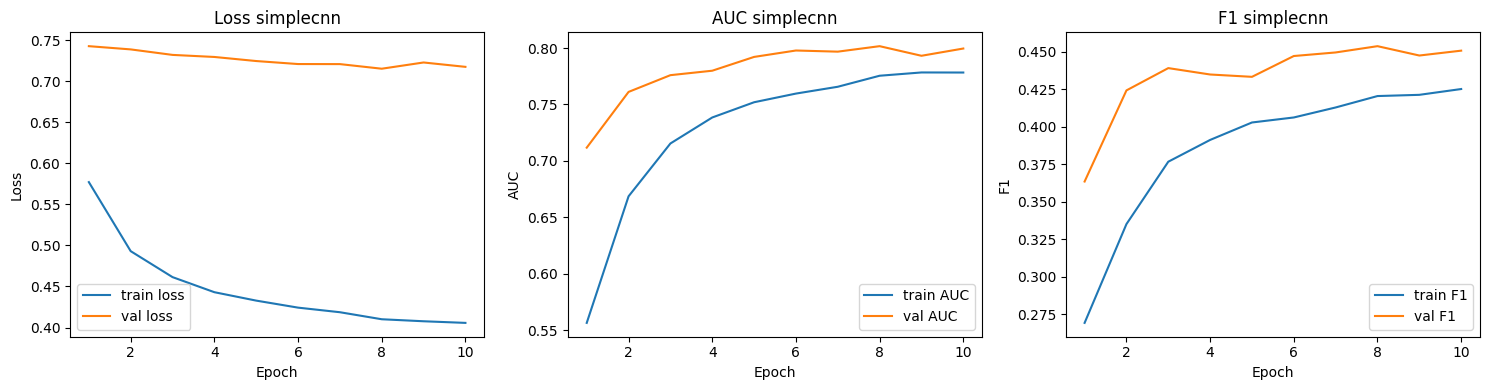

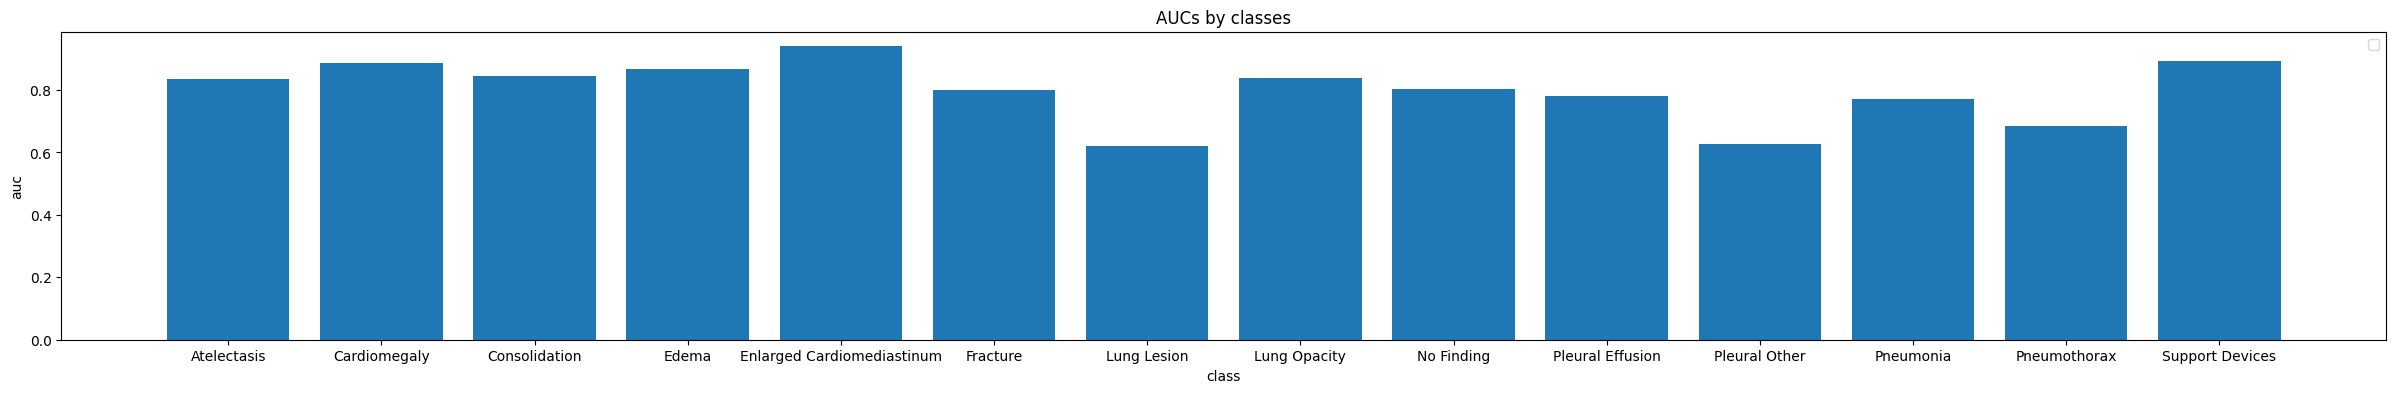

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


Model_name: resnet18


Epoch 1/10 - train: 100%|██████████| 543/543 [01:05<00:00,  8.28it/s, Loss=0.44]


Epoch 1 train loss: 0.44

Train metrics
AUC: 0.7
F1: 0.4
Precision: 0.5
Recall: 0.4

Problematic classes:
  Atelectasis: AUC=0.780, F1=0.634
  Cardiomegaly: AUC=0.825, F1=0.635
  Consolidation: AUC=0.823, F1=0.580
  Edema: AUC=0.784, F1=0.476
  Fracture: AUC=0.665, F1=0.016
  Lung Lesion: AUC=0.576, F1=0.034
  No Finding: AUC=0.767, F1=0.523
  Pleural Effusion: AUC=0.768, F1=0.580
  Pleural Other: AUC=0.561, F1=0.007
  Pneumonia: AUC=0.688, F1=0.056
  Pneumothorax: AUC=0.571, F1=0.030
  Support Devices: AUC=0.818, F1=0.650


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.99it/s]


Epoch 1 validation loss: 0.71

Validation metrics
AUC: 0.8
F1: 0.5
Precision: 0.5
Recall: 0.5

Problematic classes:
  Edema: AUC=0.885, F1=0.659
  Fracture: AUC=0.836, F1=0.000
  Lung Lesion: AUC=0.659, F1=0.000
  No Finding: AUC=0.836, F1=0.630
  Pleural Effusion: AUC=0.844, F1=0.659
  Pleural Other: AUC=0.721, F1=0.000
  Pneumonia: AUC=0.824, F1=0.095
  Pneumothorax: AUC=0.721, F1=0.000


Epoch 2/10 - train: 100%|██████████| 543/543 [01:03<00:00,  8.55it/s, Loss=0.38]


Epoch 2 train loss: 0.38

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.5
Recall: 0.4

Problematic classes:
  Consolidation: AUC=0.870, F1=0.669
  Edema: AUC=0.857, F1=0.597
  Fracture: AUC=0.792, F1=0.062
  Lung Lesion: AUC=0.635, F1=0.020
  No Finding: AUC=0.826, F1=0.601
  Pleural Effusion: AUC=0.813, F1=0.622
  Pleural Other: AUC=0.693, F1=0.000
  Pneumonia: AUC=0.766, F1=0.114
  Pneumothorax: AUC=0.653, F1=0.000


Validation: 100%|██████████| 136/136 [00:14<00:00,  9.08it/s]


Epoch 2 validation loss: 0.71

Validation metrics
AUC: 0.8
F1: 0.5
Precision: 0.5
Recall: 0.5

Problematic classes:
  Edema: AUC=0.894, F1=0.687
  Fracture: AUC=0.853, F1=0.183
  Lung Lesion: AUC=0.682, F1=0.000
  No Finding: AUC=0.842, F1=0.634
  Pleural Effusion: AUC=0.849, F1=0.681
  Pleural Other: AUC=0.765, F1=0.000
  Pneumonia: AUC=0.827, F1=0.177
  Pneumothorax: AUC=0.765, F1=0.000


Epoch 3/10 - train: 100%|██████████| 543/543 [01:04<00:00,  8.47it/s, Loss=0.37]


Epoch 3 train loss: 0.37

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Consolidation: AUC=0.879, F1=0.679
  Edema: AUC=0.868, F1=0.613
  Fracture: AUC=0.810, F1=0.122
  Lung Lesion: AUC=0.688, F1=0.035
  No Finding: AUC=0.836, F1=0.610
  Pleural Effusion: AUC=0.833, F1=0.649
  Pleural Other: AUC=0.738, F1=0.007
  Pneumonia: AUC=0.782, F1=0.126
  Pneumothorax: AUC=0.664, F1=0.000


Validation: 100%|██████████| 136/136 [00:14<00:00,  9.13it/s]


Epoch 3 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Consolidation: AUC=0.889, F1=0.700
  Fracture: AUC=0.880, F1=0.213
  Lung Lesion: AUC=0.710, F1=0.000
  No Finding: AUC=0.858, F1=0.688
  Pleural Effusion: AUC=0.863, F1=0.668
  Pleural Other: AUC=0.795, F1=0.000
  Pneumonia: AUC=0.851, F1=0.144
  Pneumothorax: AUC=0.794, F1=0.000


Epoch 4/10 - train: 100%|██████████| 543/543 [01:06<00:00,  8.19it/s, Loss=0.35]


Epoch 4 train loss: 0.35

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.877, F1=0.640
  Fracture: AUC=0.849, F1=0.195
  Lung Lesion: AUC=0.712, F1=0.064
  No Finding: AUC=0.850, F1=0.643
  Pleural Effusion: AUC=0.860, F1=0.688
  Pleural Other: AUC=0.776, F1=0.000
  Pneumonia: AUC=0.811, F1=0.205
  Pneumothorax: AUC=0.690, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.97it/s]


Epoch 4 validation loss: 0.70

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Fracture: AUC=0.860, F1=0.253
  Lung Lesion: AUC=0.698, F1=0.045
  No Finding: AUC=0.851, F1=0.634
  Pleural Effusion: AUC=0.866, F1=0.683
  Pleural Other: AUC=0.779, F1=0.000
  Pneumonia: AUC=0.846, F1=0.105
  Pneumothorax: AUC=0.777, F1=0.000


Epoch 5/10 - train: 100%|██████████| 543/543 [01:05<00:00,  8.27it/s, Loss=0.35]


Epoch 5 train loss: 0.35

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Edema: AUC=0.884, F1=0.662
  Fracture: AUC=0.858, F1=0.250
  Lung Lesion: AUC=0.726, F1=0.140
  No Finding: AUC=0.847, F1=0.625
  Pleural Effusion: AUC=0.862, F1=0.691
  Pleural Other: AUC=0.807, F1=0.015
  Pneumonia: AUC=0.813, F1=0.232
  Pneumothorax: AUC=0.702, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  9.01it/s]


Epoch 5 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Fracture: AUC=0.861, F1=0.318
  Lung Lesion: AUC=0.701, F1=0.112
  No Finding: AUC=0.834, F1=0.626
  Pleural Effusion: AUC=0.865, F1=0.663
  Pleural Other: AUC=0.810, F1=0.027
  Pneumonia: AUC=0.840, F1=0.160
  Pneumothorax: AUC=0.777, F1=0.000


Epoch 6/10 - train: 100%|██████████| 543/543 [01:04<00:00,  8.36it/s, Loss=0.34]


Epoch 6 train loss: 0.34

Train metrics
AUC: 0.9
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Edema: AUC=0.897, F1=0.677
  Fracture: AUC=0.871, F1=0.370
  Lung Lesion: AUC=0.753, F1=0.176
  No Finding: AUC=0.863, F1=0.660
  Pleural Other: AUC=0.808, F1=0.043
  Pneumonia: AUC=0.831, F1=0.326
  Pneumothorax: AUC=0.721, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.99it/s]


Epoch 6 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.6
Precision: 0.7
Recall: 0.6

Problematic classes:
  Fracture: AUC=0.893, F1=0.542
  Lung Lesion: AUC=0.728, F1=0.121
  No Finding: AUC=0.849, F1=0.640
  Pleural Other: AUC=0.815, F1=0.104
  Pneumonia: AUC=0.865, F1=0.423
  Pneumothorax: AUC=0.809, F1=0.000


Epoch 7/10 - train: 100%|██████████| 543/543 [01:04<00:00,  8.36it/s, Loss=0.33]


Epoch 7 train loss: 0.33

Train metrics
AUC: 0.9
F1: 0.6
Precision: 0.7
Recall: 0.5

Problematic classes:
  Edema: AUC=0.898, F1=0.662
  Fracture: AUC=0.875, F1=0.364
  Lung Lesion: AUC=0.750, F1=0.210
  No Finding: AUC=0.874, F1=0.676
  Pleural Other: AUC=0.828, F1=0.057
  Pneumonia: AUC=0.835, F1=0.351
  Pneumothorax: AUC=0.726, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.85it/s]


Epoch 7 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.6
Precision: 0.6
Recall: 0.6

Problematic classes:
  Fracture: AUC=0.896, F1=0.400
  Lung Lesion: AUC=0.750, F1=0.165
  No Finding: AUC=0.859, F1=0.652
  Pleural Effusion: AUC=0.873, F1=0.698
  Pleural Other: AUC=0.815, F1=0.077
  Pneumonia: AUC=0.863, F1=0.374
  Pneumothorax: AUC=0.775, F1=0.000


Epoch 8/10 - train: 100%|██████████| 543/543 [01:06<00:00,  8.13it/s, Loss=0.32]


Epoch 8 train loss: 0.32

Train metrics
AUC: 0.9
F1: 0.6
Precision: 0.8
Recall: 0.5

Problematic classes:
  Edema: AUC=0.901, F1=0.686
  Fracture: AUC=0.885, F1=0.419
  Lung Lesion: AUC=0.773, F1=0.232
  No Finding: AUC=0.870, F1=0.671
  Pleural Other: AUC=0.835, F1=0.096
  Pneumonia: AUC=0.854, F1=0.380
  Pneumothorax: AUC=0.743, F1=0.006


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.88it/s]


Epoch 8 validation loss: 0.68

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Consolidation: AUC=0.884, F1=0.663
  Edema: AUC=0.895, F1=0.543
  Fracture: AUC=0.875, F1=0.508
  Lung Lesion: AUC=0.718, F1=0.044
  No Finding: AUC=0.844, F1=0.661
  Pleural Effusion: AUC=0.867, F1=0.664
  Pleural Other: AUC=0.770, F1=0.269
  Pneumonia: AUC=0.847, F1=0.339
  Pneumothorax: AUC=0.754, F1=0.000
  Support Devices: AUC=0.926, F1=0.692


Epoch 9/10 - train: 100%|██████████| 543/543 [01:06<00:00,  8.14it/s, Loss=0.31]


Epoch 9 train loss: 0.31

Train metrics
AUC: 0.9
F1: 0.6
Precision: 0.7
Recall: 0.6

Problematic classes:
  Edema: AUC=0.906, F1=0.696
  Fracture: AUC=0.888, F1=0.450
  Lung Lesion: AUC=0.777, F1=0.247
  No Finding: AUC=0.879, F1=0.684
  Pleural Other: AUC=0.847, F1=0.179
  Pneumonia: AUC=0.857, F1=0.440
  Pneumothorax: AUC=0.761, F1=0.006


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.88it/s]


Epoch 9 validation loss: 0.68

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Consolidation: AUC=0.896, F1=0.668
  Edema: AUC=0.900, F1=0.614
  Fracture: AUC=0.883, F1=0.456
  Lung Lesion: AUC=0.734, F1=0.153
  No Finding: AUC=0.850, F1=0.663
  Pleural Effusion: AUC=0.877, F1=0.630
  Pleural Other: AUC=0.797, F1=0.120
  Pneumonia: AUC=0.852, F1=0.298
  Pneumothorax: AUC=0.766, F1=0.000


Epoch 10/10 - train: 100%|██████████| 543/543 [01:06<00:00,  8.20it/s, Loss=0.31]


Epoch 10 train loss: 0.31

Train metrics
AUC: 0.9
F1: 0.6
Precision: 0.7
Recall: 0.6

Problematic classes:
  Fracture: AUC=0.897, F1=0.487
  Lung Lesion: AUC=0.792, F1=0.291
  Pleural Other: AUC=0.856, F1=0.171
  Pneumonia: AUC=0.866, F1=0.470
  Pneumothorax: AUC=0.774, F1=0.012


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.97it/s]


Epoch 10 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.6
Precision: 0.6
Recall: 0.6

Problematic classes:
  Fracture: AUC=0.881, F1=0.514
  Lung Lesion: AUC=0.735, F1=0.238
  No Finding: AUC=0.858, F1=0.664
  Pleural Effusion: AUC=0.876, F1=0.698
  Pleural Other: AUC=0.812, F1=0.305
  Pneumonia: AUC=0.864, F1=0.514
  Pneumothorax: AUC=0.805, F1=0.044
The best validation AUC: 0.8727465867996216


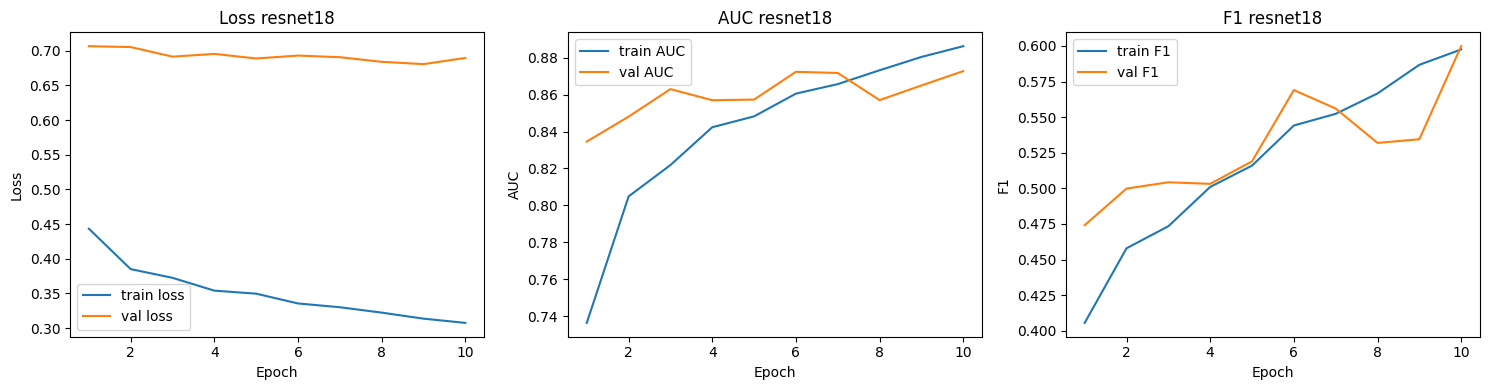

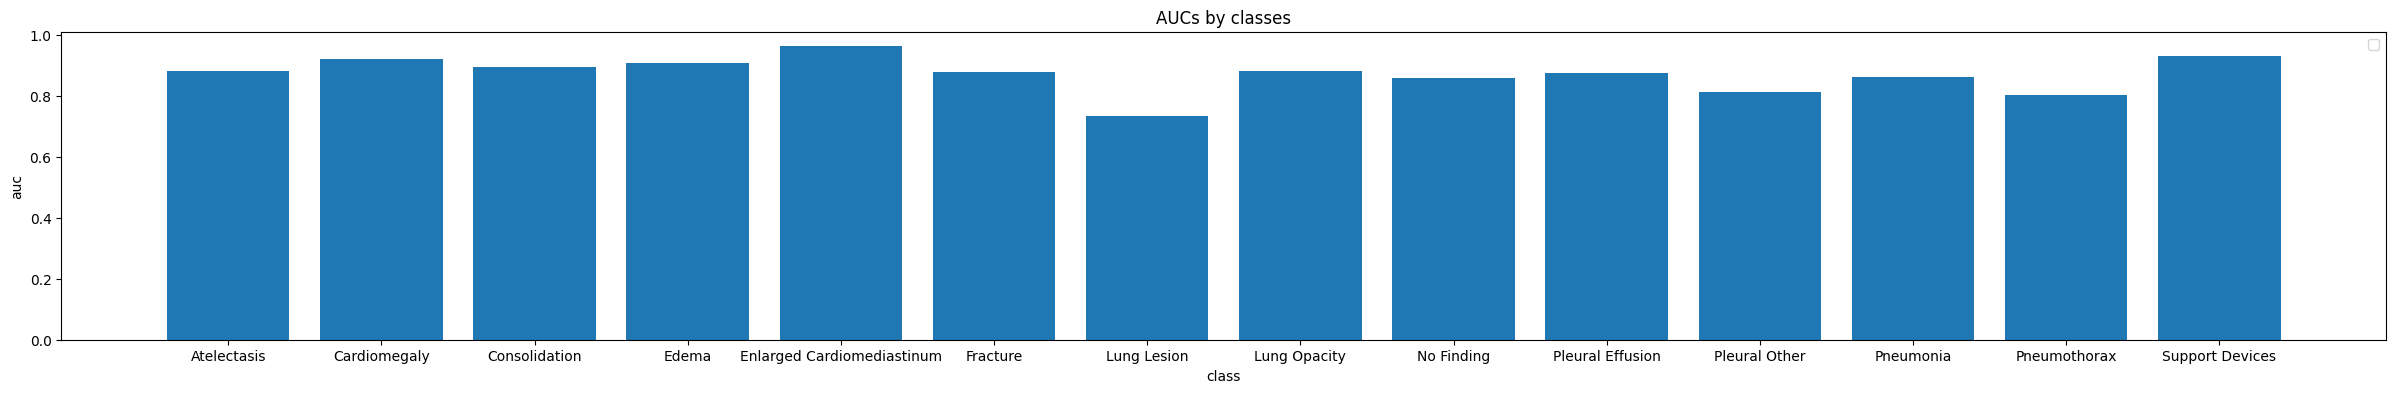

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 222MB/s]


Model_name: resnext50


Epoch 1/10 - train: 100%|██████████| 543/543 [01:13<00:00,  7.41it/s, Loss=0.42]


Epoch 1 train loss: 0.42

Train metrics
AUC: 0.8
F1: 0.4
Precision: 0.5
Recall: 0.4

Problematic classes:
  Atelectasis: AUC=0.806, F1=0.649
  Cardiomegaly: AUC=0.850, F1=0.672
  Consolidation: AUC=0.834, F1=0.600
  Edema: AUC=0.827, F1=0.506
  Fracture: AUC=0.730, F1=0.013
  Lung Lesion: AUC=0.596, F1=0.048
  No Finding: AUC=0.797, F1=0.560
  Pleural Effusion: AUC=0.773, F1=0.575
  Pleural Other: AUC=0.646, F1=0.013
  Pneumonia: AUC=0.717, F1=0.016
  Pneumothorax: AUC=0.620, F1=0.043
  Support Devices: AUC=0.854, F1=0.682


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.66it/s]


Epoch 1 validation loss: 0.71

Validation metrics
AUC: 0.8
F1: 0.5
Precision: 0.5
Recall: 0.5

Problematic classes:
  Consolidation: AUC=0.872, F1=0.690
  Edema: AUC=0.893, F1=0.692
  Fracture: AUC=0.824, F1=0.000
  Lung Lesion: AUC=0.676, F1=0.000
  No Finding: AUC=0.831, F1=0.613
  Pleural Effusion: AUC=0.833, F1=0.639
  Pleural Other: AUC=0.761, F1=0.000
  Pneumonia: AUC=0.801, F1=0.000
  Pneumothorax: AUC=0.717, F1=0.000


Epoch 2/10 - train: 100%|██████████| 543/543 [01:12<00:00,  7.44it/s, Loss=0.38]


Epoch 2 train loss: 0.38

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.6
Recall: 0.4

Problematic classes:
  Consolidation: AUC=0.873, F1=0.666
  Edema: AUC=0.856, F1=0.588
  Fracture: AUC=0.802, F1=0.067
  Lung Lesion: AUC=0.643, F1=0.012
  No Finding: AUC=0.828, F1=0.590
  Pleural Effusion: AUC=0.829, F1=0.637
  Pleural Other: AUC=0.703, F1=0.000
  Pneumonia: AUC=0.765, F1=0.077
  Pneumothorax: AUC=0.673, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.66it/s]


Epoch 2 validation loss: 0.70

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.5
Recall: 0.5

Problematic classes:
  Edema: AUC=0.895, F1=0.676
  Fracture: AUC=0.865, F1=0.092
  Lung Lesion: AUC=0.680, F1=0.000
  No Finding: AUC=0.849, F1=0.664
  Pleural Effusion: AUC=0.854, F1=0.682
  Pleural Other: AUC=0.769, F1=0.000
  Pneumonia: AUC=0.829, F1=0.055
  Pneumothorax: AUC=0.750, F1=0.000


Epoch 3/10 - train: 100%|██████████| 543/543 [01:13<00:00,  7.39it/s, Loss=0.37]


Epoch 3 train loss: 0.37

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.874, F1=0.632
  Fracture: AUC=0.829, F1=0.128
  Lung Lesion: AUC=0.662, F1=0.016
  No Finding: AUC=0.842, F1=0.623
  Pleural Effusion: AUC=0.846, F1=0.670
  Pleural Other: AUC=0.747, F1=0.000
  Pneumonia: AUC=0.800, F1=0.148
  Pneumothorax: AUC=0.679, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.54it/s]


Epoch 3 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.896, F1=0.642
  Fracture: AUC=0.858, F1=0.312
  Lung Lesion: AUC=0.705, F1=0.000
  No Finding: AUC=0.851, F1=0.646
  Pleural Effusion: AUC=0.861, F1=0.692
  Pleural Other: AUC=0.786, F1=0.000
  Pneumonia: AUC=0.829, F1=0.028
  Pneumothorax: AUC=0.714, F1=0.000


Epoch 4/10 - train: 100%|██████████| 543/543 [01:15<00:00,  7.22it/s, Loss=0.35]


Epoch 4 train loss: 0.35

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.875, F1=0.624
  Fracture: AUC=0.857, F1=0.283
  Lung Lesion: AUC=0.718, F1=0.058
  No Finding: AUC=0.857, F1=0.648
  Pleural Effusion: AUC=0.858, F1=0.690
  Pleural Other: AUC=0.785, F1=0.000
  Pneumonia: AUC=0.812, F1=0.176
  Pneumothorax: AUC=0.679, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.58it/s]


Epoch 4 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Fracture: AUC=0.880, F1=0.398
  Lung Lesion: AUC=0.715, F1=0.100
  No Finding: AUC=0.850, F1=0.634
  Pleural Effusion: AUC=0.869, F1=0.683
  Pleural Other: AUC=0.811, F1=0.000
  Pneumonia: AUC=0.852, F1=0.241
  Pneumothorax: AUC=0.758, F1=0.000


Epoch 5/10 - train: 100%|██████████| 543/543 [01:14<00:00,  7.32it/s, Loss=0.34]


Epoch 5 train loss: 0.34

Train metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.892, F1=0.671
  Fracture: AUC=0.858, F1=0.345
  Lung Lesion: AUC=0.737, F1=0.120
  No Finding: AUC=0.866, F1=0.660
  Pleural Effusion: AUC=0.868, F1=0.698
  Pleural Other: AUC=0.788, F1=0.015
  Pneumonia: AUC=0.819, F1=0.265
  Pneumothorax: AUC=0.730, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.69it/s]


Epoch 5 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Fracture: AUC=0.853, F1=0.388
  Lung Lesion: AUC=0.728, F1=0.101
  No Finding: AUC=0.847, F1=0.659
  Pleural Effusion: AUC=0.871, F1=0.668
  Pleural Other: AUC=0.774, F1=0.000
  Pneumonia: AUC=0.833, F1=0.269
  Pneumothorax: AUC=0.715, F1=0.000


Epoch 6/10 - train: 100%|██████████| 543/543 [01:12<00:00,  7.47it/s, Loss=0.33]


Epoch 6 train loss: 0.33

Train metrics
AUC: 0.9
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Edema: AUC=0.897, F1=0.674
  Fracture: AUC=0.872, F1=0.359
  Lung Lesion: AUC=0.744, F1=0.185
  No Finding: AUC=0.865, F1=0.656
  Pleural Other: AUC=0.818, F1=0.022
  Pneumonia: AUC=0.842, F1=0.329
  Pneumothorax: AUC=0.734, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.73it/s]


Epoch 6 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Edema: AUC=0.899, F1=0.665
  Fracture: AUC=0.870, F1=0.351
  Lung Lesion: AUC=0.732, F1=0.139
  No Finding: AUC=0.844, F1=0.627
  Pleural Effusion: AUC=0.864, F1=0.691
  Pleural Other: AUC=0.799, F1=0.054
  Pneumonia: AUC=0.835, F1=0.294
  Pneumothorax: AUC=0.751, F1=0.000


Epoch 7/10 - train: 100%|██████████| 543/543 [01:14<00:00,  7.33it/s, Loss=0.32]


Epoch 7 train loss: 0.32

Train metrics
AUC: 0.9
F1: 0.6
Precision: 0.7
Recall: 0.5

Problematic classes:
  Edema: AUC=0.903, F1=0.686
  Fracture: AUC=0.889, F1=0.431
  Lung Lesion: AUC=0.779, F1=0.198
  No Finding: AUC=0.876, F1=0.679
  Pleural Other: AUC=0.827, F1=0.069
  Pneumonia: AUC=0.856, F1=0.415
  Pneumothorax: AUC=0.724, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.69it/s]


Epoch 7 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.6
Precision: 0.6
Recall: 0.6

Problematic classes:
  Edema: AUC=0.900, F1=0.685
  Fracture: AUC=0.875, F1=0.498
  Lung Lesion: AUC=0.742, F1=0.282
  No Finding: AUC=0.853, F1=0.641
  Pleural Effusion: AUC=0.868, F1=0.692
  Pleural Other: AUC=0.798, F1=0.051
  Pneumonia: AUC=0.856, F1=0.463
  Pneumothorax: AUC=0.791, F1=0.000


Epoch 8/10 - train: 100%|██████████| 543/543 [01:12<00:00,  7.46it/s, Loss=0.31]


Epoch 8 train loss: 0.31

Train metrics
AUC: 0.9
F1: 0.6
Precision: 0.7
Recall: 0.6

Problematic classes:
  Fracture: AUC=0.893, F1=0.474
  Lung Lesion: AUC=0.788, F1=0.260
  Pleural Other: AUC=0.845, F1=0.144
  Pneumonia: AUC=0.869, F1=0.448
  Pneumothorax: AUC=0.769, F1=0.006


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.56it/s]


Epoch 8 validation loss: 0.68

Validation metrics
AUC: 0.9
F1: 0.6
Precision: 0.7
Recall: 0.5

Problematic classes:
  Fracture: AUC=0.879, F1=0.412
  Lung Lesion: AUC=0.759, F1=0.292
  No Finding: AUC=0.853, F1=0.672
  Pleural Effusion: AUC=0.881, F1=0.654
  Pleural Other: AUC=0.791, F1=0.171
  Pneumonia: AUC=0.869, F1=0.502
  Pneumothorax: AUC=0.799, F1=0.000


Epoch 9/10 - train: 100%|██████████| 543/543 [01:13<00:00,  7.37it/s, Loss=0.30]


Epoch 9 train loss: 0.30

Train metrics
AUC: 0.9
F1: 0.6
Precision: 0.7
Recall: 0.6

Problematic classes:
  Fracture: AUC=0.906, F1=0.502
  Lung Lesion: AUC=0.801, F1=0.303
  Pleural Other: AUC=0.867, F1=0.222
  Pneumonia: AUC=0.866, F1=0.473
  Pneumothorax: AUC=0.778, F1=0.006


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.66it/s]


Epoch 9 validation loss: 0.68

Validation metrics
AUC: 0.9
F1: 0.6
Precision: 0.6
Recall: 0.6

Problematic classes:
  Fracture: AUC=0.866, F1=0.490
  Lung Lesion: AUC=0.764, F1=0.218
  No Finding: AUC=0.859, F1=0.691
  Pleural Other: AUC=0.798, F1=0.136
  Pneumonia: AUC=0.855, F1=0.428
  Pneumothorax: AUC=0.787, F1=0.000


Epoch 10/10 - train: 100%|██████████| 543/543 [01:12<00:00,  7.48it/s, Loss=0.29]


Epoch 10 train loss: 0.29

Train metrics
AUC: 0.9
F1: 0.6
Precision: 0.7
Recall: 0.6

Problematic classes:
  Fracture: AUC=0.910, F1=0.559
  Lung Lesion: AUC=0.815, F1=0.336
  Pleural Other: AUC=0.866, F1=0.265
  Pneumonia: AUC=0.887, F1=0.530
  Pneumothorax: AUC=0.798, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.72it/s]


Epoch 10 validation loss: 0.68

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Cardiomegaly: AUC=0.898, F1=0.696
  Consolidation: AUC=0.897, F1=0.694
  Edema: AUC=0.885, F1=0.585
  Fracture: AUC=0.856, F1=0.462
  Lung Lesion: AUC=0.755, F1=0.242
  No Finding: AUC=0.847, F1=0.673
  Pleural Effusion: AUC=0.871, F1=0.662
  Pleural Other: AUC=0.790, F1=0.191
  Pneumonia: AUC=0.855, F1=0.469
  Pneumothorax: AUC=0.783, F1=0.000
  Support Devices: AUC=0.926, F1=0.696
The best validation AUC: 0.873791515827179


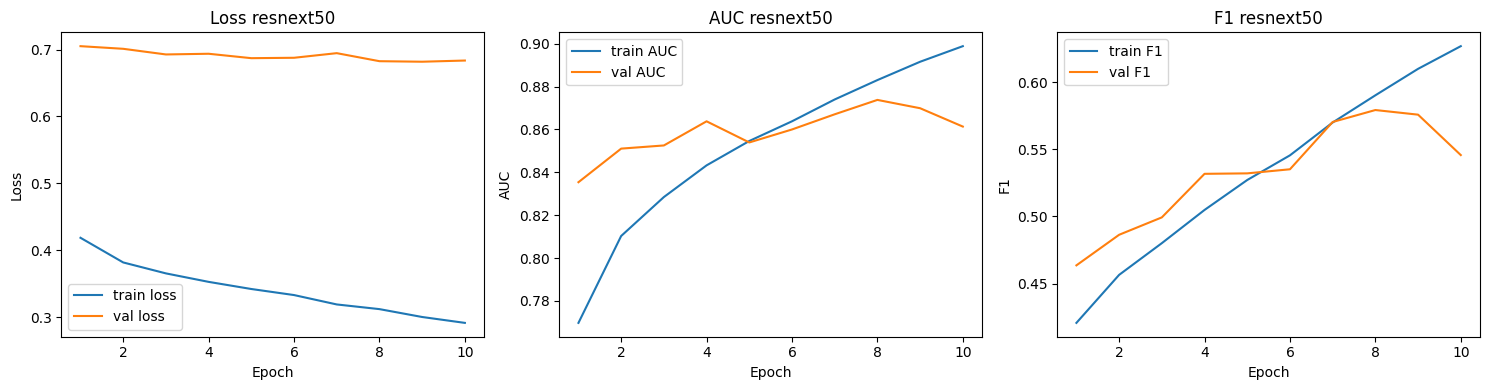

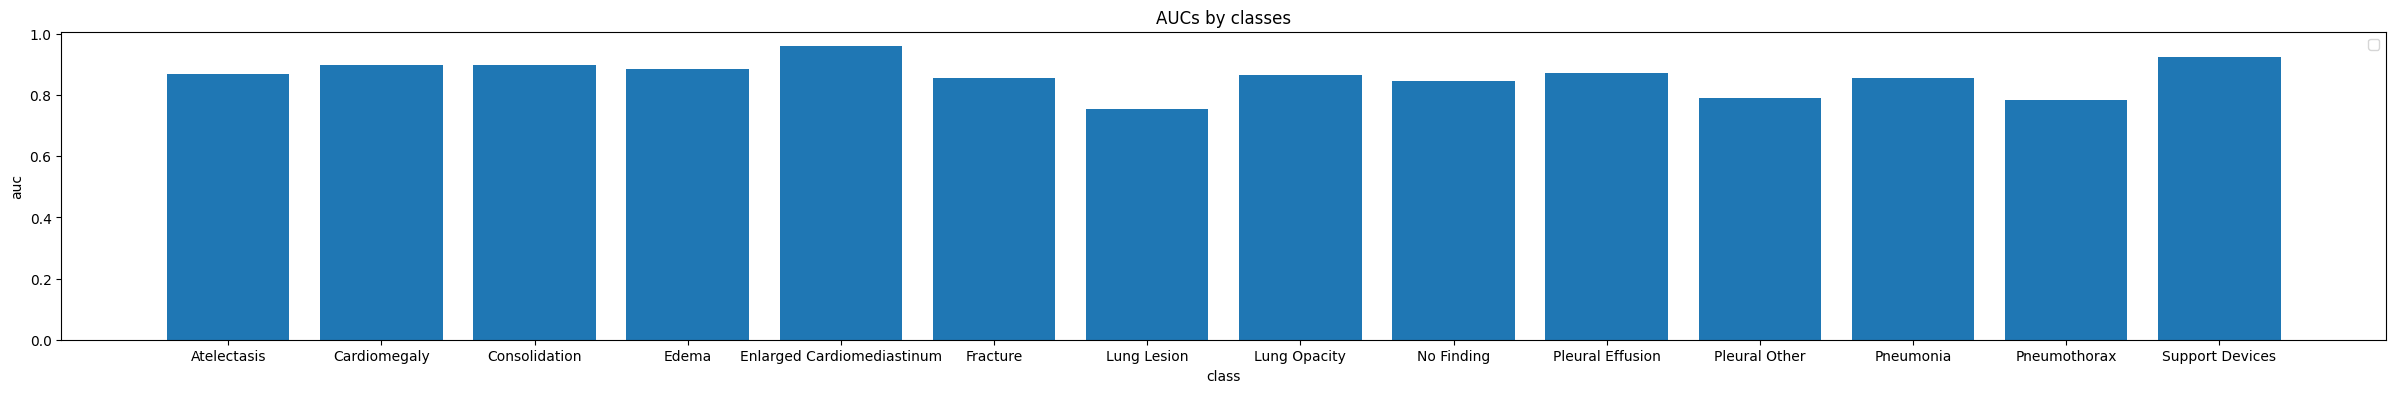

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 145MB/s]


Model_name: efficientnet_b0


Epoch 1/10 - train: 100%|██████████| 543/543 [01:07<00:00,  7.99it/s, Loss=0.46]


Epoch 1 train loss: 0.46

Train metrics
AUC: 0.7
F1: 0.4
Precision: 0.4
Recall: 0.3

Problematic classes:
  Atelectasis: AUC=0.762, F1=0.583
  Cardiomegaly: AUC=0.801, F1=0.547
  Consolidation: AUC=0.779, F1=0.520
  Edema: AUC=0.789, F1=0.454
  Fracture: AUC=0.670, F1=0.024
  Lung Lesion: AUC=0.541, F1=0.031
  Lung Opacity: AUC=0.790, F1=0.694
  No Finding: AUC=0.739, F1=0.471
  Pleural Effusion: AUC=0.725, F1=0.538
  Pleural Other: AUC=0.528, F1=0.000
  Pneumonia: AUC=0.662, F1=0.006
  Pneumothorax: AUC=0.563, F1=0.020
  Support Devices: AUC=0.828, F1=0.640


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.93it/s]


Epoch 1 validation loss: 0.71

Validation metrics
AUC: 0.8
F1: 0.5
Precision: 0.4
Recall: 0.5

Problematic classes:
  Consolidation: AUC=0.854, F1=0.676
  Edema: AUC=0.874, F1=0.676
  Fracture: AUC=0.755, F1=0.000
  Lung Lesion: AUC=0.611, F1=0.000
  No Finding: AUC=0.814, F1=0.608
  Pleural Effusion: AUC=0.788, F1=0.601
  Pleural Other: AUC=0.609, F1=0.000
  Pneumonia: AUC=0.783, F1=0.000
  Pneumothorax: AUC=0.711, F1=0.000


Epoch 2/10 - train: 100%|██████████| 543/543 [01:06<00:00,  8.15it/s, Loss=0.40]


Epoch 2 train loss: 0.40

Train metrics
AUC: 0.8
F1: 0.4
Precision: 0.5
Recall: 0.4

Problematic classes:
  Atelectasis: AUC=0.819, F1=0.692
  Consolidation: AUC=0.860, F1=0.644
  Edema: AUC=0.852, F1=0.601
  Fracture: AUC=0.759, F1=0.006
  Lung Lesion: AUC=0.620, F1=0.000
  No Finding: AUC=0.807, F1=0.573
  Pleural Effusion: AUC=0.796, F1=0.604
  Pleural Other: AUC=0.631, F1=0.000
  Pneumonia: AUC=0.745, F1=0.013
  Pneumothorax: AUC=0.641, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.89it/s]


Epoch 2 validation loss: 0.71

Validation metrics
AUC: 0.8
F1: 0.5
Precision: 0.4
Recall: 0.5

Problematic classes:
  Consolidation: AUC=0.865, F1=0.698
  Edema: AUC=0.886, F1=0.698
  Fracture: AUC=0.807, F1=0.000
  Lung Lesion: AUC=0.634, F1=0.000
  No Finding: AUC=0.828, F1=0.595
  Pleural Effusion: AUC=0.812, F1=0.626
  Pleural Other: AUC=0.657, F1=0.000
  Pneumonia: AUC=0.800, F1=0.000
  Pneumothorax: AUC=0.728, F1=0.000


Epoch 3/10 - train: 100%|██████████| 543/543 [01:07<00:00,  8.08it/s, Loss=0.39]


Epoch 3 train loss: 0.38

Train metrics
AUC: 0.8
F1: 0.4
Precision: 0.5
Recall: 0.4

Problematic classes:
  Atelectasis: AUC=0.826, F1=0.693
  Consolidation: AUC=0.867, F1=0.663
  Edema: AUC=0.864, F1=0.629
  Fracture: AUC=0.792, F1=0.013
  Lung Lesion: AUC=0.636, F1=0.000
  No Finding: AUC=0.818, F1=0.578
  Pleural Effusion: AUC=0.804, F1=0.603
  Pleural Other: AUC=0.683, F1=0.000
  Pneumonia: AUC=0.754, F1=0.016
  Pneumothorax: AUC=0.661, F1=0.000


Validation: 100%|██████████| 136/136 [00:14<00:00,  9.09it/s]


Epoch 3 validation loss: 0.71

Validation metrics
AUC: 0.8
F1: 0.5
Precision: 0.5
Recall: 0.5

Problematic classes:
  Fracture: AUC=0.831, F1=0.041
  Lung Lesion: AUC=0.645, F1=0.000
  No Finding: AUC=0.842, F1=0.640
  Pleural Effusion: AUC=0.822, F1=0.643
  Pleural Other: AUC=0.709, F1=0.000
  Pneumonia: AUC=0.804, F1=0.000
  Pneumothorax: AUC=0.751, F1=0.000


Epoch 4/10 - train: 100%|██████████| 543/543 [01:06<00:00,  8.15it/s, Loss=0.38]


Epoch 4 train loss: 0.38

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.5
Recall: 0.4

Problematic classes:
  Consolidation: AUC=0.878, F1=0.676
  Edema: AUC=0.866, F1=0.640
  Fracture: AUC=0.809, F1=0.032
  Lung Lesion: AUC=0.632, F1=0.000
  No Finding: AUC=0.831, F1=0.605
  Pleural Effusion: AUC=0.813, F1=0.622
  Pleural Other: AUC=0.720, F1=0.000
  Pneumonia: AUC=0.770, F1=0.038
  Pneumothorax: AUC=0.641, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.82it/s]


Epoch 4 validation loss: 0.70

Validation metrics
AUC: 0.8
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.894, F1=0.696
  Fracture: AUC=0.846, F1=0.028
  Lung Lesion: AUC=0.651, F1=0.000
  No Finding: AUC=0.849, F1=0.653
  Pleural Effusion: AUC=0.834, F1=0.633
  Pleural Other: AUC=0.760, F1=0.000
  Pneumonia: AUC=0.803, F1=0.014
  Pneumothorax: AUC=0.765, F1=0.000


Epoch 5/10 - train: 100%|██████████| 543/543 [01:07<00:00,  8.01it/s, Loss=0.37]


Epoch 5 train loss: 0.37

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.5
Recall: 0.4

Problematic classes:
  Consolidation: AUC=0.883, F1=0.691
  Edema: AUC=0.878, F1=0.650
  Fracture: AUC=0.826, F1=0.050
  Lung Lesion: AUC=0.683, F1=0.000
  No Finding: AUC=0.837, F1=0.613
  Pleural Effusion: AUC=0.825, F1=0.631
  Pleural Other: AUC=0.756, F1=0.000
  Pneumonia: AUC=0.786, F1=0.032
  Pneumothorax: AUC=0.688, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  9.01it/s]


Epoch 5 validation loss: 0.69

Validation metrics
AUC: 0.8
F1: 0.5
Precision: 0.5
Recall: 0.5

Problematic classes:
  Consolidation: AUC=0.884, F1=0.700
  Edema: AUC=0.894, F1=0.676
  Fracture: AUC=0.836, F1=0.118
  Lung Lesion: AUC=0.667, F1=0.000
  No Finding: AUC=0.848, F1=0.668
  Pleural Effusion: AUC=0.842, F1=0.632
  Pleural Other: AUC=0.762, F1=0.000
  Pneumonia: AUC=0.804, F1=0.000
  Pneumothorax: AUC=0.754, F1=0.000


Epoch 6/10 - train: 100%|██████████| 543/543 [01:06<00:00,  8.14it/s, Loss=0.35]


Epoch 6 train loss: 0.35

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.883, F1=0.662
  Fracture: AUC=0.844, F1=0.142
  Lung Lesion: AUC=0.684, F1=0.000
  No Finding: AUC=0.853, F1=0.648
  Pleural Effusion: AUC=0.847, F1=0.667
  Pleural Other: AUC=0.793, F1=0.000
  Pneumonia: AUC=0.816, F1=0.071
  Pneumothorax: AUC=0.701, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.93it/s]


Epoch 6 validation loss: 0.70

Validation metrics
AUC: 0.8
F1: 0.5
Precision: 0.5
Recall: 0.5

Problematic classes:
  Fracture: AUC=0.853, F1=0.204
  Lung Lesion: AUC=0.667, F1=0.000
  No Finding: AUC=0.856, F1=0.664
  Pleural Effusion: AUC=0.851, F1=0.675
  Pleural Other: AUC=0.764, F1=0.000
  Pneumonia: AUC=0.809, F1=0.079
  Pneumothorax: AUC=0.750, F1=0.000


Epoch 7/10 - train: 100%|██████████| 543/543 [01:06<00:00,  8.21it/s, Loss=0.35]


Epoch 7 train loss: 0.35

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.883, F1=0.660
  Fracture: AUC=0.853, F1=0.192
  Lung Lesion: AUC=0.671, F1=0.004
  No Finding: AUC=0.852, F1=0.639
  Pleural Effusion: AUC=0.853, F1=0.668
  Pleural Other: AUC=0.779, F1=0.000
  Pneumonia: AUC=0.810, F1=0.087
  Pneumothorax: AUC=0.710, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  9.03it/s]


Epoch 7 validation loss: 0.70

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.900, F1=0.683
  Fracture: AUC=0.854, F1=0.312
  Lung Lesion: AUC=0.677, F1=0.000
  No Finding: AUC=0.853, F1=0.655
  Pleural Effusion: AUC=0.854, F1=0.672
  Pleural Other: AUC=0.768, F1=0.000
  Pneumonia: AUC=0.822, F1=0.055
  Pneumothorax: AUC=0.749, F1=0.000


Epoch 8/10 - train: 100%|██████████| 543/543 [01:05<00:00,  8.24it/s, Loss=0.34]


Epoch 8 train loss: 0.34

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Edema: AUC=0.886, F1=0.669
  Fracture: AUC=0.861, F1=0.270
  Lung Lesion: AUC=0.693, F1=0.008
  No Finding: AUC=0.858, F1=0.656
  Pleural Effusion: AUC=0.855, F1=0.672
  Pleural Other: AUC=0.803, F1=0.007
  Pneumonia: AUC=0.817, F1=0.131
  Pneumothorax: AUC=0.699, F1=0.000


Validation: 100%|██████████| 136/136 [00:14<00:00,  9.08it/s]


Epoch 8 validation loss: 0.70

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.5
Recall: 0.5

Problematic classes:
  Edema: AUC=0.896, F1=0.699
  Fracture: AUC=0.858, F1=0.365
  Lung Lesion: AUC=0.702, F1=0.000
  No Finding: AUC=0.862, F1=0.654
  Pleural Effusion: AUC=0.856, F1=0.683
  Pleural Other: AUC=0.780, F1=0.000
  Pneumonia: AUC=0.837, F1=0.182
  Pneumothorax: AUC=0.775, F1=0.000


Epoch 9/10 - train: 100%|██████████| 543/543 [01:06<00:00,  8.11it/s, Loss=0.34]


Epoch 9 train loss: 0.34

Train metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.894, F1=0.670
  Fracture: AUC=0.871, F1=0.289
  Lung Lesion: AUC=0.722, F1=0.008
  No Finding: AUC=0.869, F1=0.677
  Pleural Effusion: AUC=0.867, F1=0.694
  Pleural Other: AUC=0.813, F1=0.000
  Pneumonia: AUC=0.828, F1=0.163
  Pneumothorax: AUC=0.707, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.89it/s]


Epoch 9 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.896, F1=0.681
  Fracture: AUC=0.853, F1=0.402
  Lung Lesion: AUC=0.700, F1=0.000
  No Finding: AUC=0.848, F1=0.637
  Pleural Effusion: AUC=0.858, F1=0.694
  Pleural Other: AUC=0.772, F1=0.000
  Pneumonia: AUC=0.826, F1=0.263
  Pneumothorax: AUC=0.767, F1=0.000


Epoch 10/10 - train: 100%|██████████| 543/543 [01:07<00:00,  8.10it/s, Loss=0.33]


Epoch 10 train loss: 0.33

Train metrics
AUC: 0.9
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Edema: AUC=0.899, F1=0.685
  Fracture: AUC=0.880, F1=0.329
  Lung Lesion: AUC=0.706, F1=0.016
  No Finding: AUC=0.869, F1=0.666
  Pleural Other: AUC=0.817, F1=0.015
  Pneumonia: AUC=0.828, F1=0.197
  Pneumothorax: AUC=0.717, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.89it/s]


Epoch 10 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.899, F1=0.686
  Fracture: AUC=0.862, F1=0.450
  Lung Lesion: AUC=0.713, F1=0.000
  No Finding: AUC=0.857, F1=0.669
  Pleural Effusion: AUC=0.863, F1=0.683
  Pleural Other: AUC=0.793, F1=0.000
  Pneumonia: AUC=0.840, F1=0.245
  Pneumothorax: AUC=0.776, F1=0.000
The best validation AUC: 0.8611077070236206


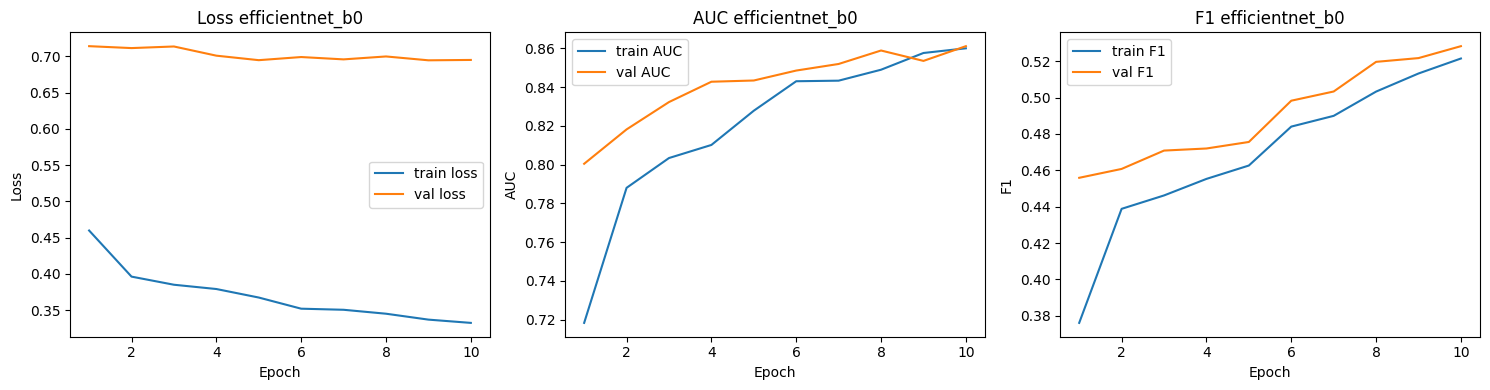

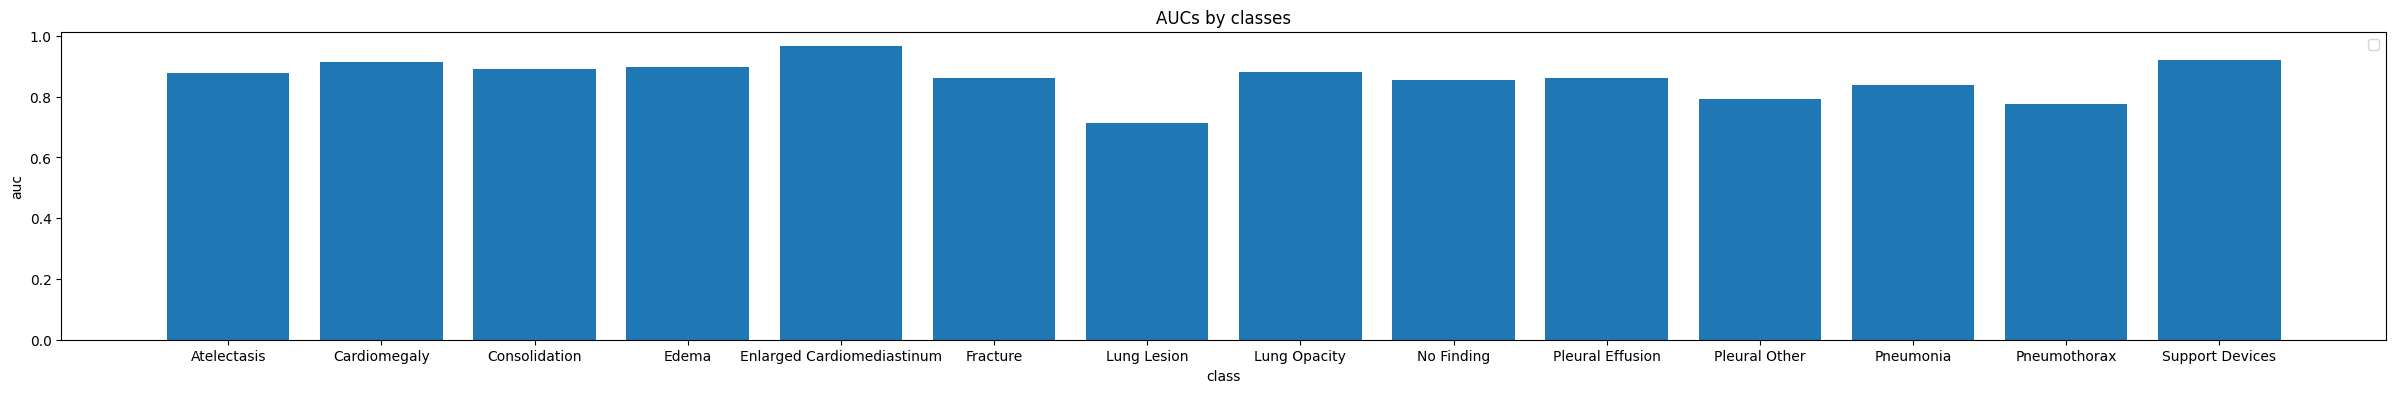

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 174MB/s]


Model_name: densenet121


Epoch 1/10 - train: 100%|██████████| 543/543 [01:11<00:00,  7.55it/s, Loss=0.44]


Epoch 1 train loss: 0.44

Train metrics
AUC: 0.7
F1: 0.4
Precision: 0.5
Recall: 0.4

Problematic classes:
  Atelectasis: AUC=0.778, F1=0.600
  Cardiomegaly: AUC=0.824, F1=0.642
  Consolidation: AUC=0.808, F1=0.527
  Edema: AUC=0.795, F1=0.449
  Fracture: AUC=0.697, F1=0.062
  Lung Lesion: AUC=0.563, F1=0.054
  Lung Opacity: AUC=0.793, F1=0.694
  No Finding: AUC=0.775, F1=0.493
  Pleural Effusion: AUC=0.748, F1=0.480
  Pleural Other: AUC=0.600, F1=0.050
  Pneumonia: AUC=0.672, F1=0.063
  Pneumothorax: AUC=0.612, F1=0.048
  Support Devices: AUC=0.824, F1=0.629


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.73it/s]


Epoch 1 validation loss: 0.72

Validation metrics
AUC: 0.8
F1: 0.4
Precision: 0.4
Recall: 0.5

Problematic classes:
  Consolidation: AUC=0.866, F1=0.687
  Fracture: AUC=0.829, F1=0.000
  Lung Lesion: AUC=0.641, F1=0.000
  No Finding: AUC=0.837, F1=0.477
  Pleural Effusion: AUC=0.829, F1=0.655
  Pleural Other: AUC=0.753, F1=0.000
  Pneumonia: AUC=0.802, F1=0.000
  Pneumothorax: AUC=0.730, F1=0.000


Epoch 2/10 - train: 100%|██████████| 543/543 [01:12<00:00,  7.49it/s, Loss=0.39]


Epoch 2 train loss: 0.39

Train metrics
AUC: 0.8
F1: 0.4
Precision: 0.5
Recall: 0.4

Problematic classes:
  Atelectasis: AUC=0.832, F1=0.694
  Consolidation: AUC=0.866, F1=0.643
  Edema: AUC=0.846, F1=0.589
  Fracture: AUC=0.793, F1=0.065
  Lung Lesion: AUC=0.616, F1=0.004
  No Finding: AUC=0.827, F1=0.598
  Pleural Effusion: AUC=0.822, F1=0.616
  Pleural Other: AUC=0.698, F1=0.000
  Pneumonia: AUC=0.757, F1=0.013
  Pneumothorax: AUC=0.663, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.76it/s]


Epoch 2 validation loss: 0.71

Validation metrics
AUC: 0.8
F1: 0.5
Precision: 0.5
Recall: 0.5

Problematic classes:
  Edema: AUC=0.888, F1=0.700
  Fracture: AUC=0.849, F1=0.054
  Lung Lesion: AUC=0.657, F1=0.000
  No Finding: AUC=0.839, F1=0.537
  Pleural Effusion: AUC=0.849, F1=0.674
  Pleural Other: AUC=0.751, F1=0.000
  Pneumonia: AUC=0.806, F1=0.000
  Pneumothorax: AUC=0.774, F1=0.000


Epoch 3/10 - train: 100%|██████████| 543/543 [01:11<00:00,  7.61it/s, Loss=0.37]


Epoch 3 train loss: 0.37

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.5
Recall: 0.4

Problematic classes:
  Consolidation: AUC=0.875, F1=0.668
  Edema: AUC=0.864, F1=0.619
  Fracture: AUC=0.808, F1=0.093
  Lung Lesion: AUC=0.644, F1=0.000
  No Finding: AUC=0.841, F1=0.628
  Pleural Effusion: AUC=0.835, F1=0.657
  Pleural Other: AUC=0.744, F1=0.000
  Pneumonia: AUC=0.770, F1=0.032
  Pneumothorax: AUC=0.669, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.73it/s]


Epoch 3 validation loss: 0.70

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.5
Recall: 0.5

Problematic classes:
  Edema: AUC=0.890, F1=0.691
  Fracture: AUC=0.861, F1=0.068
  Lung Lesion: AUC=0.691, F1=0.000
  No Finding: AUC=0.843, F1=0.659
  Pleural Effusion: AUC=0.855, F1=0.678
  Pleural Other: AUC=0.773, F1=0.000
  Pneumonia: AUC=0.826, F1=0.000
  Pneumothorax: AUC=0.765, F1=0.000


Epoch 4/10 - train: 100%|██████████| 543/543 [01:11<00:00,  7.55it/s, Loss=0.37]


Epoch 4 train loss: 0.37

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Consolidation: AUC=0.885, F1=0.674
  Edema: AUC=0.869, F1=0.622
  Fracture: AUC=0.821, F1=0.117
  Lung Lesion: AUC=0.663, F1=0.012
  No Finding: AUC=0.842, F1=0.621
  Pleural Effusion: AUC=0.848, F1=0.667
  Pleural Other: AUC=0.750, F1=0.000
  Pneumonia: AUC=0.772, F1=0.047
  Pneumothorax: AUC=0.678, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.70it/s]


Epoch 4 validation loss: 0.70

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.5
Recall: 0.5

Problematic classes:
  Edema: AUC=0.900, F1=0.696
  Fracture: AUC=0.858, F1=0.129
  Lung Lesion: AUC=0.698, F1=0.000
  No Finding: AUC=0.835, F1=0.614
  Pleural Effusion: AUC=0.867, F1=0.697
  Pleural Other: AUC=0.770, F1=0.000
  Pneumonia: AUC=0.827, F1=0.000
  Pneumothorax: AUC=0.758, F1=0.000


Epoch 5/10 - train: 100%|██████████| 543/543 [01:11<00:00,  7.58it/s, Loss=0.35]


Epoch 5 train loss: 0.35

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.882, F1=0.645
  Fracture: AUC=0.844, F1=0.230
  Lung Lesion: AUC=0.679, F1=0.004
  No Finding: AUC=0.853, F1=0.644
  Pleural Effusion: AUC=0.864, F1=0.686
  Pleural Other: AUC=0.768, F1=0.000
  Pneumonia: AUC=0.801, F1=0.077
  Pneumothorax: AUC=0.717, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.66it/s]


Epoch 5 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.896, F1=0.690
  Fracture: AUC=0.852, F1=0.186
  Lung Lesion: AUC=0.708, F1=0.000
  No Finding: AUC=0.839, F1=0.653
  Pleural Effusion: AUC=0.870, F1=0.693
  Pleural Other: AUC=0.793, F1=0.000
  Pneumonia: AUC=0.835, F1=0.095
  Pneumothorax: AUC=0.775, F1=0.000


Epoch 6/10 - train: 100%|██████████| 543/543 [01:11<00:00,  7.62it/s, Loss=0.35]


Epoch 6 train loss: 0.35

Train metrics
AUC: 0.8
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.885, F1=0.668
  Fracture: AUC=0.844, F1=0.219
  Lung Lesion: AUC=0.707, F1=0.024
  No Finding: AUC=0.858, F1=0.657
  Pleural Effusion: AUC=0.869, F1=0.699
  Pleural Other: AUC=0.785, F1=0.000
  Pneumonia: AUC=0.816, F1=0.143
  Pneumothorax: AUC=0.709, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.77it/s]


Epoch 6 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.895, F1=0.690
  Fracture: AUC=0.871, F1=0.355
  Lung Lesion: AUC=0.693, F1=0.122
  No Finding: AUC=0.850, F1=0.658
  Pleural Effusion: AUC=0.869, F1=0.689
  Pleural Other: AUC=0.801, F1=0.000
  Pneumonia: AUC=0.841, F1=0.381
  Pneumothorax: AUC=0.760, F1=0.000


Epoch 7/10 - train: 100%|██████████| 543/543 [01:11<00:00,  7.61it/s, Loss=0.34]


Epoch 7 train loss: 0.34

Train metrics
AUC: 0.9
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Edema: AUC=0.889, F1=0.677
  Fracture: AUC=0.855, F1=0.275
  Lung Lesion: AUC=0.737, F1=0.020
  No Finding: AUC=0.862, F1=0.650
  Pleural Other: AUC=0.798, F1=0.007
  Pneumonia: AUC=0.820, F1=0.231
  Pneumothorax: AUC=0.732, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.75it/s]


Epoch 7 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Fracture: AUC=0.867, F1=0.320
  Lung Lesion: AUC=0.729, F1=0.045
  No Finding: AUC=0.860, F1=0.687
  Pleural Other: AUC=0.790, F1=0.000
  Pneumonia: AUC=0.848, F1=0.178
  Pneumothorax: AUC=0.775, F1=0.000


Epoch 8/10 - train: 100%|██████████| 543/543 [01:11<00:00,  7.63it/s, Loss=0.33]


Epoch 8 train loss: 0.33

Train metrics
AUC: 0.9
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Edema: AUC=0.897, F1=0.666
  Fracture: AUC=0.871, F1=0.326
  Lung Lesion: AUC=0.740, F1=0.058
  No Finding: AUC=0.869, F1=0.674
  Pleural Other: AUC=0.811, F1=0.015
  Pneumonia: AUC=0.824, F1=0.198
  Pneumothorax: AUC=0.737, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.74it/s]


Epoch 8 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.6

Problematic classes:
  Fracture: AUC=0.860, F1=0.404
  Lung Lesion: AUC=0.710, F1=0.114
  No Finding: AUC=0.851, F1=0.668
  Pleural Other: AUC=0.774, F1=0.000
  Pneumonia: AUC=0.846, F1=0.376
  Pneumothorax: AUC=0.746, F1=0.000


Epoch 9/10 - train: 100%|██████████| 543/543 [01:11<00:00,  7.60it/s, Loss=0.33]


Epoch 9 train loss: 0.33

Train metrics
AUC: 0.9
F1: 0.5
Precision: 0.7
Recall: 0.5

Problematic classes:
  Edema: AUC=0.901, F1=0.681
  Fracture: AUC=0.863, F1=0.355
  Lung Lesion: AUC=0.768, F1=0.078
  No Finding: AUC=0.876, F1=0.685
  Pleural Other: AUC=0.825, F1=0.007
  Pneumonia: AUC=0.835, F1=0.266
  Pneumothorax: AUC=0.737, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.72it/s]


Epoch 9 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Edema: AUC=0.901, F1=0.699
  Fracture: AUC=0.859, F1=0.295
  Lung Lesion: AUC=0.746, F1=0.191
  No Finding: AUC=0.850, F1=0.669
  Pleural Effusion: AUC=0.873, F1=0.691
  Pleural Other: AUC=0.774, F1=0.000
  Pneumonia: AUC=0.831, F1=0.398
  Pneumothorax: AUC=0.751, F1=0.000


Epoch 10/10 - train: 100%|██████████| 543/543 [01:11<00:00,  7.63it/s, Loss=0.32]


Epoch 10 train loss: 0.32

Train metrics
AUC: 0.9
F1: 0.6
Precision: 0.7
Recall: 0.5

Problematic classes:
  Fracture: AUC=0.880, F1=0.374
  Lung Lesion: AUC=0.766, F1=0.154
  No Finding: AUC=0.884, F1=0.695
  Pleural Other: AUC=0.829, F1=0.015
  Pneumonia: AUC=0.837, F1=0.323
  Pneumothorax: AUC=0.742, F1=0.000


Validation: 100%|██████████| 136/136 [00:15<00:00,  8.79it/s]


Epoch 10 validation loss: 0.69

Validation metrics
AUC: 0.9
F1: 0.5
Precision: 0.6
Recall: 0.5

Problematic classes:
  Fracture: AUC=0.862, F1=0.406
  Lung Lesion: AUC=0.715, F1=0.203
  No Finding: AUC=0.837, F1=0.616
  Pleural Other: AUC=0.763, F1=0.000
  Pneumonia: AUC=0.824, F1=0.323
  Pneumothorax: AUC=0.729, F1=0.000
The best validation AUC: 0.8646711707115173


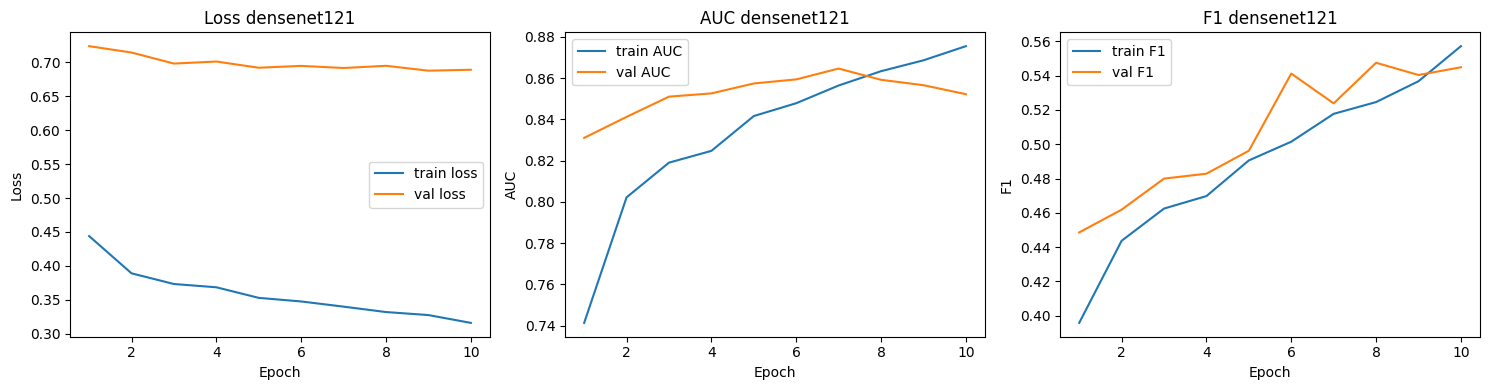

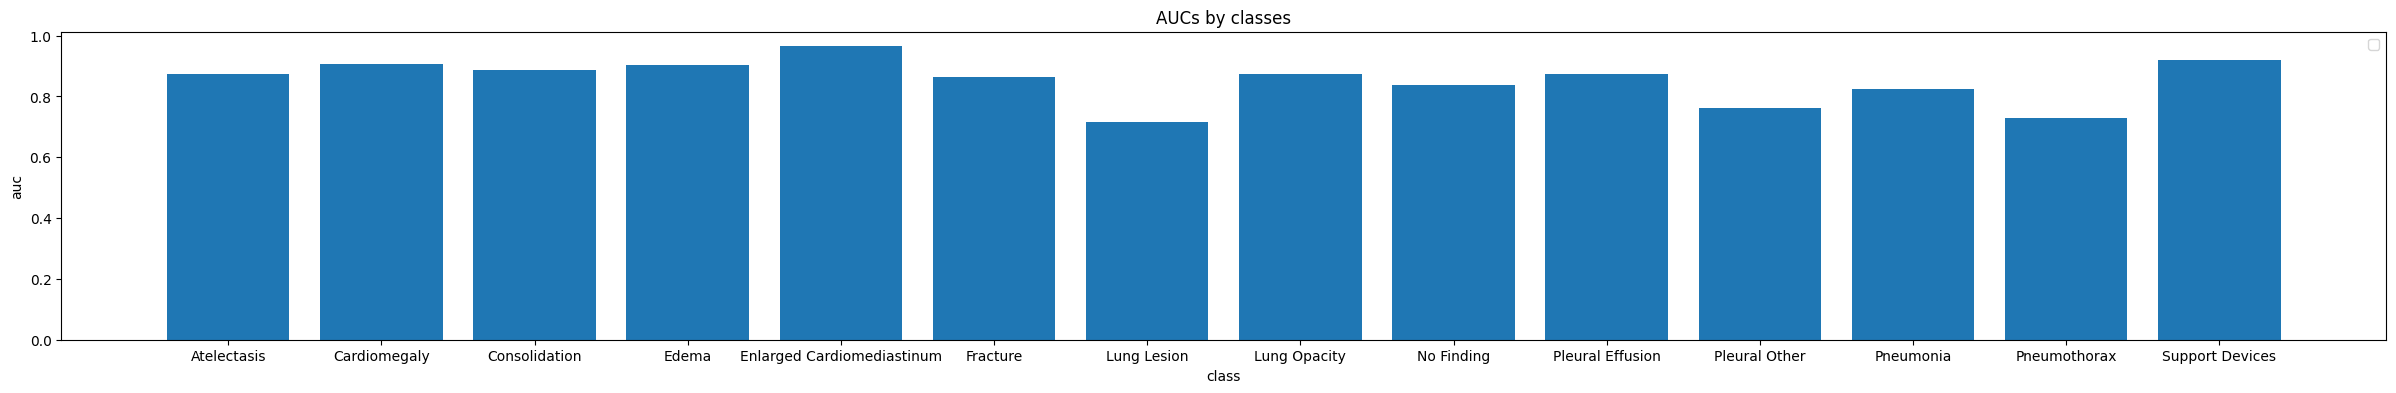

In [ ]:
for model_name in MODEL_NAMES:
    model = CNNWrapper(model_name)
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.BCEWithLogitsLoss()
    training_and_validation(model_name, model, optimizer, criterion)